In [1]:
!pip install -q torch_snippets
from torch_snippets import *
device = "cuda" if torch.cuda.is_available() else "cpu"
from torchvision.utils import make_grid

Exception in thread Thread-5 (attachment_entry):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 237, in listen
    sock, _ = endpoints_listener.accept()
  File "/usr/lib/python3.10/socket.py", line 293, in accept
    fd, addr = self._accept()
TimeoutError: timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_debugpy.py", line 52, in attachment_entry
    debugpy.listen(_dap_port)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/public_api.py", line 31, in wrapper
    return wrapped(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 143, in debug
    log.reraise

In [2]:
from torchvision.datasets import MNIST
from torchvision import transforms

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,))
])

data_loader = torch.utils.data.DataLoader(MNIST('~/data', train=True, download=True, transform=transform), batch_size=128, shuffle=True, drop_last=True)

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    def forward(self, x): return self.model(x)

In [4]:
from torchsummary import summary
discriminator = Discriminator().to(device)
summary(discriminator, (1, 784));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 1, 1024]         803,840
         LeakyReLU-2              [-1, 1, 1024]               0
           Dropout-3              [-1, 1, 1024]               0
            Linear-4               [-1, 1, 512]         524,800
         LeakyReLU-5               [-1, 1, 512]               0
           Dropout-6               [-1, 1, 512]               0
            Linear-7               [-1, 1, 256]         131,328
         LeakyReLU-8               [-1, 1, 256]               0
           Dropout-9               [-1, 1, 256]               0
           Linear-10                 [-1, 1, 1]             257
          Sigmoid-11                 [-1, 1, 1]               0
Total params: 1,460,225
Trainable params: 1,460,225
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, x): return self.model(x)

In [6]:
generator = Generator().to(device)
summary(generator, (1,100));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 256]          25,856
         LeakyReLU-2               [-1, 1, 256]               0
            Linear-3               [-1, 1, 512]         131,584
         LeakyReLU-4               [-1, 1, 512]               0
            Linear-5              [-1, 1, 1024]         525,312
         LeakyReLU-6              [-1, 1, 1024]               0
            Linear-7               [-1, 1, 784]         803,600
              Tanh-8               [-1, 1, 784]               0
Total params: 1,486,352
Trainable params: 1,486,352
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 5.67
Estimated Total Size (MB): 5.71
----------------------------------------------------------------


In [7]:
def noise(size):
    n = torch.randn(size, 100)
    return n.to(device)

In [8]:
def discriminator_train_step(real_data, fake_data):
    d_optimizer.zero_grad()
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real, torch.ones(len(real_data), 1).to(device))
    error_real.backward()
    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake, torch.zeros(len(fake_data), 1).to(device))
    error_fake.backward()
    d_optimizer.step()
    return error_real + error_fake

In [9]:
def generator_train_step(fake_data):
    g_optimizer.zero_grad()
    prediction = discriminator(fake_data)
    error = loss(prediction, torch.ones(len(real_data), 1).to(device))
    error.backward()
    g_optimizer.step()
    return error

In [10]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
loss = nn.BCELoss()
num_epochs = 200
log = Report(num_epochs)

EPOCH: 1.000  g_loss: 3.501  d_loss: 0.813  (23.92s - 4760.56s remaining)
EPOCH: 2.000  g_loss: 2.977  d_loss: 0.860  (44.88s - 4442.83s remaining)
EPOCH: 3.000  g_loss: 1.736  d_loss: 1.028  (66.77s - 4384.31s remaining)
EPOCH: 4.000  g_loss: 2.490  d_loss: 0.681  (82.77s - 4055.95s remaining)
EPOCH: 5.000  g_loss: 2.796  d_loss: 0.510  (99.59s - 3884.14s remaining)
EPOCH: 6.000  g_loss: 3.405  d_loss: 0.422  (115.42s - 3731.94s remaining)
EPOCH: 7.000  g_loss: 3.207  d_loss: 0.482  (133.45s - 3679.31s remaining)
EPOCH: 8.000  g_loss: 2.516  d_loss: 0.635  (150.62s - 3614.90s remaining)
EPOCH: 9.000  g_loss: 2.503  d_loss: 0.602  (167.04s - 3544.98s remaining)
EPOCH: 10.000  g_loss: 2.154  d_loss: 0.693  (183.12s - 3479.32s remaining)
EPOCH: 11.000  g_loss: 2.507  d_loss: 0.582  (199.31s - 3424.51s remaining)
EPOCH: 12.000  g_loss: 2.442  d_loss: 0.619  (215.76s - 3380.22s remaining)
EPOCH: 13.000  g_loss: 2.300  d_loss: 0.691  (231.67s - 3332.46s remaining)
EPOCH: 14.000  g_loss: 2.4

100%|██████████| 301/301 [00:09<00:00, 30.78it/s]


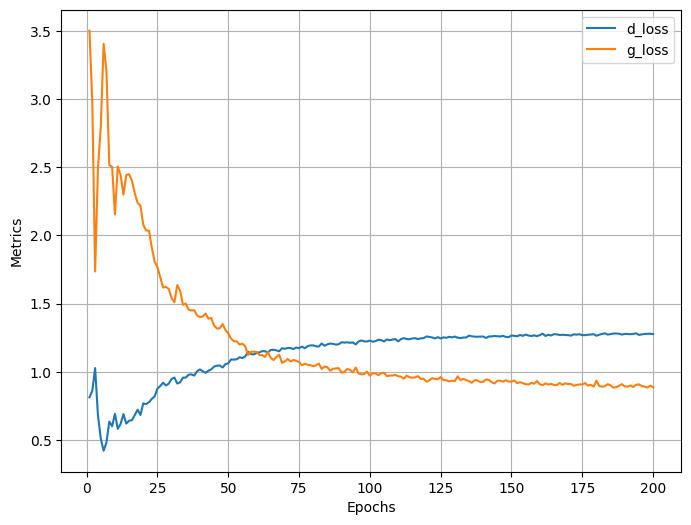

In [11]:
for epoch in range(num_epochs):
    N = len(data_loader)
    for i, (images, _) in enumerate(data_loader):
        real_data = images.view(len(images), -1).to(device)
        fake_data = generator(noise(len(real_data))).to(device)
        fake_data = fake_data.detach()
        d_loss = discriminator_train_step(real_data, fake_data)
        fake_data = generator(noise(len(real_data))).to(device)
        g_loss = generator_train_step(fake_data)
        log.record(epoch+(1+i)/N, d_loss=d_loss.item(), g_loss=g_loss.item(), end='\r')
    log.report_avgs(epoch+1)
log.plot_epochs(['d_loss', 'g_loss'])

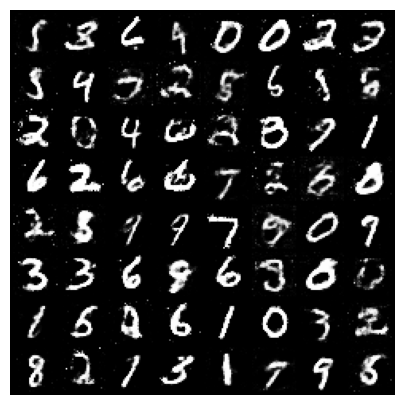

In [12]:
z = torch.randn(64, 100).to(device)
sample_images = generator(z).data.cpu().view(64, 1, 28, 28)
grid = make_grid(sample_images, nrow=8, normalize=True)
show(grid.cpu().detach().permute(1,2,0), sz=5)

---